In [1]:
import ast
import matplotlib.pyplot as plt
from minisom import MiniSom
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score,
                             adjusted_mutual_info_score, calinski_harabasz_score,
                             silhouette_score, davies_bouldin_score)
import sklearn.preprocessing as skl_p
from scipy.spatial import distance_matrix

In [2]:
rng = np.random.default_rng()

In [3]:
genres = ["rock",
          "classical",
          "latin",
          "pop",
          "jazz",
          "soul",
          "classic bollywood",
          "rap",
          "fold",
          "funk",
          "opera"]
tracks = pd.read_csv('../data/tracks_with_genres.csv')
tracks['genres'] = tracks['genres'].apply(ast.literal_eval)
tracks = tracks.explode('genres')
tracks.rename(columns={'genres': 'genre'}, inplace=True)
tracks_subset = tracks[tracks['genre'].isin(genres)]

In [4]:
tracks_genres = tracks_subset['genre'].astype('category')
labels_integers = tracks_genres.cat.codes

## Data
A subset of the data has been used for clustering in this notebook.
The distribution of the data between genres can be seen in the following plot.

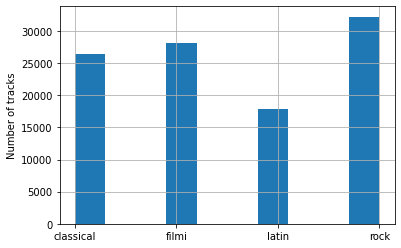

In total, there are 104438 tracks in the dataset used.


In [5]:
tracks_subset['genre'].hist()
plt.ylabel('Number of tracks')
plt.show()
print(f'In total, there are {tracks_subset.shape[0]} tracks in the dataset used.')


Convert the pandas dataframe to a matrix of numerical values, normalize the values column wise and shuffle the rows.

In [6]:
#features = ['acousticness', 'instrumentalness']
features = ['acousticness', 'instrumentalness', 'loudness', 'energy', 'danceability', 'valence', 'explicit']
tracks_values = tracks_subset[features].values
tracks_values = (tracks_values - tracks_values.mean(axis=0))/tracks_values.std(axis=0)
rng.shuffle(tracks_values, axis=0)

Train the SOM and plot the resulting activation map

 [ 208876 / 208876 ] 100% - 0:00:00 left 
 quantization error: 0.39190544738351096


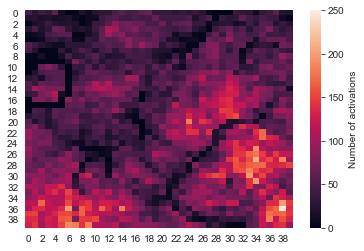

In [7]:
som_neurons = (40, 40)

som = MiniSom(som_neurons[0], som_neurons[1], tracks_values.shape[1],
              sigma=1, learning_rate=0.1)

som.train(tracks_values, tracks_values.shape[0]*2, verbose=True)

neuron_activations = som.activation_response(tracks_values)

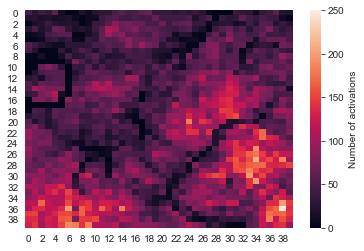

In [16]:
sns.set_style('white')
heatmap = sns.heatmap(neuron_activations, cbar_kws={'label': 'Number of activations'})
#plt.axis('off')
plt.show()
heatmap.get_figure().savefig('../figures/neurons_heatmap.png')

Display the distance map.

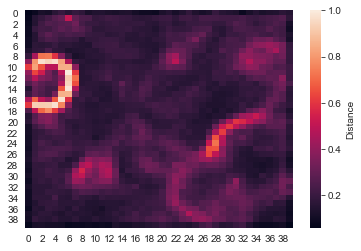

In [17]:
sns.set_style('white')
heatmap = sns.heatmap(som.distance_map(), cbar_kws={'label': 'Distance'})
#plt.axis('off')
plt.show()
heatmap.get_figure().savefig('../figures/neurons_distance_map.png')

Save the model (if needed)

In [8]:
with open('../models/som.p', 'wb') as model_file:
    pickle.dump(som, model_file)

Load the model (if needed)

In [195]:
with open('../models/som.p', 'rb') as model_file:
    som = pickle.load(model_file)

Cluster the SOM using DBSCAN, show resulting clustering and display Silhouette score

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
14


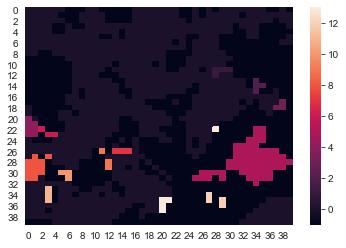

Silhouette score: -0.379 (closer to 1 is better)
Davies-Bouldin score: 1.875 (lower is better)


In [19]:
dbscan = DBSCAN(eps=0.5, n_jobs=-1, min_samples=3)
som_weights = som.get_weights()
labels = dbscan.fit_predict(
    som_weights.reshape(som_neurons[0]*som_neurons[1], len(features)))

print(np.unique(labels))

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters)

labels_matrix = labels.reshape(som_neurons[0], som_neurons[1])
heatmap = sns.heatmap(labels_matrix)
plt.show()
heatmap.get_figure().savefig('../figures/neurons_clustered.png')
silhouette = silhouette_score(som_weights.reshape(som_neurons[0]*som_neurons[1], len(features)),
                              labels)
davies_bouldin = davies_bouldin_score(som_weights.reshape(som_neurons[0]*som_neurons[1], len(features)),
                                      labels)

print(f'Silhouette score: {silhouette:.3f} (closer to 1 is better)')
print(f'Davies-Bouldin score: {davies_bouldin:.3f} (lower is better)')

1600
[0 1 2 3]


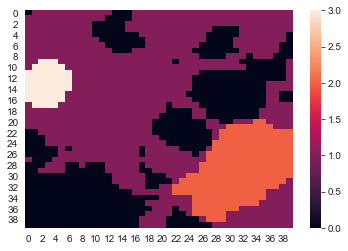

In [40]:
cluster = AgglomerativeClustering(n_clusters=len(genres))
som_weights = som.get_weights()
labels = cluster.fit_predict(
    som_weights.reshape(som_neurons[0]*som_neurons[1], len(features))
)
print(len(labels))
print(np.unique(labels))

labels_matrix = labels.reshape(som_neurons[0], som_neurons[1])
sns.heatmap(labels_matrix)
plt.show()

1600
[0 1 2 3]


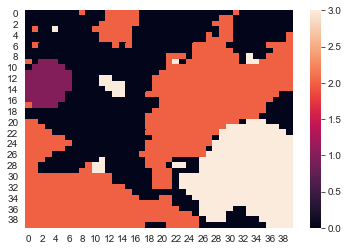

In [38]:
cluster = MiniBatchKMeans(n_clusters=len(genres))
som_weights = som.get_weights()
labels = cluster.fit_predict(
    som_weights.reshape(som_neurons[0]*som_neurons[1], len(features))
)
print(len(labels))
print(np.unique(labels))

labels_matrix = labels.reshape(som_neurons[0], som_neurons[1])
sns.heatmap(labels_matrix)
plt.show()

Assign genres to the clusters

In [48]:
labels_map = som.labels_map(tracks_values, labels_integers)

In [70]:
cluster_counts = np.zeros((len(genres), len(genres)))

neuron_activations_flat = neuron_activations.flatten()
labels_map_flat = labels_map.flatten()
for neuron in range(30):
    label = labels[neuron]
    counter = labels_map[(neuron//som_neurons[1], neuron%som_neurons[1])]
    np_counter = np.array(counter)
    print(np_counter)
    #print(neuron_activations_flat[neuron])

#print(labels_map.keys())
print(labels_map[(12, 13)])
#print(dir(labels_map))

AttributeError: 'collections.defaultdict' object has no attribute 'flatten'

Running epoch 1/100
 [ 104438 / 104438 ] 100% - 0:00:00 left 
 quantization error: 0.8702861180071821
Silhouette score: 0.056
Davies-Bouldin score: 2.737 (lower is better)
Calinski-Harabasz score: 109.615 (higher is better)

Running epoch 2/100
 [ 104438 / 104438 ] 100% - 0:00:00 left 
 quantization error: 0.7726925017340021
Silhouette score: 0.077
Davies-Bouldin score: 2.445 (lower is better)
Calinski-Harabasz score: 125.158 (higher is better)

Running epoch 3/100
 [ 104438 / 104438 ] 100% - 0:00:00 left 
 quantization error: 0.7263772342603961
Silhouette score: 0.088
Davies-Bouldin score: 1.975 (lower is better)
Calinski-Harabasz score: 134.497 (higher is better)

Running epoch 4/100
 [ 104438 / 104438 ] 100% - 0:00:00 left 
 quantization error: 0.6978228000408012
Silhouette score: 0.145
Davies-Bouldin score: 1.475 (lower is better)
Calinski-Harabasz score: 159.569 (higher is better)

Running epoch 5/100
 [ 104438 / 104438 ] 100% - 0:00:00 left 
 quantization error: 0.676052338889801

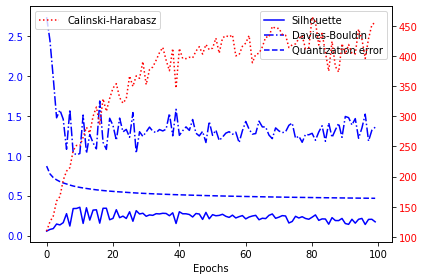

In [9]:
# Epoch learning, if that is helpful
som_neurons = (40, 40)
epochs = 100
learning_rate = 0.001
sigma = 1

som = MiniSom(som_neurons[0], som_neurons[1], len(features),
                  sigma=sigma, learning_rate=learning_rate)
cluster = AgglomerativeClustering(n_clusters=len(genres))

quantization_errors = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for i in range(epochs):
    print(f'Running epoch {i+1}/{epochs}')
    som.train(tracks_values, tracks_values.shape[0], verbose=True)
    quantization_errors.append(som.quantization_error(tracks_values))

    som_weights = som.get_weights()
    labels = cluster.fit_predict(
        som_weights.reshape(som_neurons[0]*som_neurons[1], len(features)))
    silhouette = silhouette_score(som_weights.reshape(som_neurons[0]*som_neurons[1], len(features)),
                       labels)
    davies_bouldin = davies_bouldin_score(som_weights.reshape(som_neurons[0]*som_neurons[1], len(features)),
                                      labels)
    calinski_harabasz = calinski_harabasz_score(som_weights.reshape(som_neurons[0]*som_neurons[1], len(features)),
                                      labels)

    print(f'Silhouette score: {silhouette:.3f}')
    print(f'Davies-Bouldin score: {davies_bouldin:.3f} (lower is better)')
    print(f'Calinski-Harabasz score: {calinski_harabasz:.3f} (higher is better)\n')

    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

fig, ax1 = plt.subplots()
ax1.plot(silhouette_scores, color='b', linestyle='-', label='Silhouette')
ax1.plot(davies_bouldin_scores, color='b', linestyle='-.', label='Davies-Bouldin')
ax1.plot(quantization_errors, color='b', linestyle='--', label='Quantization error')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel('Epochs')

ax2 = plt.twinx()
ax2.plot(calinski_harabasz_scores, color='r', linestyle=':', label='Calinski-Harabasz')
ax2.tick_params(axis='y', labelcolor='r')
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.savefig(f'../figures/epoch_training_lr_{learning_rate}_sigma_{sigma}.png')
plt.show()

with open(f'../models/epoch_training_lr_{learning_rate}_sigma_{sigma}.p', 'wb') as model_file:
    pickle.dump(som, model_file)

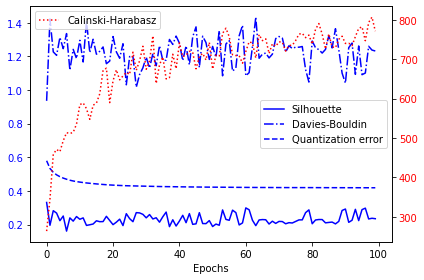

In [8]:
fig, ax1 = plt.subplots()
ax1.plot(silhouette_scores, color='b', linestyle='-', label='Silhouette')
ax1.plot(davies_bouldin_scores, color='b', linestyle='-.', label='Davies-Bouldin')
ax1.plot(quantization_errors, color='b', linestyle='--', label='Quantization error')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel('Epochs')

ax2 = plt.twinx()
ax2.plot(calinski_harabasz_scores, color='r', linestyle=':', label='Calinski-Harabasz')
ax2.tick_params(axis='y', labelcolor='r')
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.savefig(f'../figures/epoch_training_lr_{learning_rate}_sigma_{sigma}.png')
plt.show()

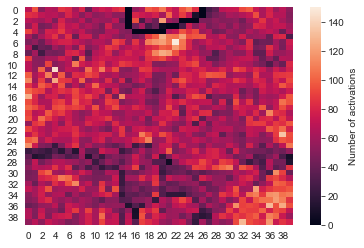

In [10]:
neuron_activations = som.activation_response(tracks_values)

sns.set_style('white')
heatmap = sns.heatmap(neuron_activations, cbar_kws={'label': 'Number of activations'})
#plt.axis('off')
plt.show()

## Evaluation

In [355]:
print(silhouette_score(som_weights.reshape(som_neurons[0]*som_neurons[1], len(features)),
                       labels))

-0.3727483874858323


## Visualization
First we visualize a heat map of the SOM neurons.

Then the clustering of the SOM neurons.

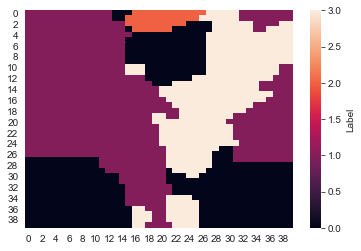

In [11]:
labels_matrix = labels.reshape(som_neurons[0], som_neurons[1])
sns.heatmap(labels.reshape(som_neurons[0], som_neurons[1]), cbar_kws={'label': 'Label'})
plt.show()


Finally, the weights of the features.

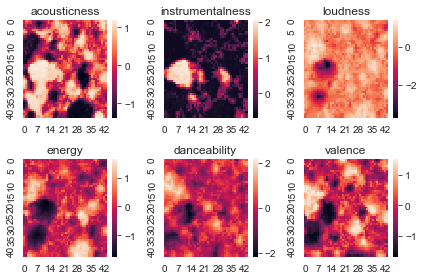

In [294]:
# Feature importance
sns.set_style('white')
fig, axs = plt.subplots(2, 3)

for i, feature in enumerate(features):
    ax = axs[i//3, i%3]
    sns.heatmap(som_weights[:, :, i], ax=ax)
    ax.set_title(feature)
plt.tight_layout()
plt.show()